# Visual Analysis of Rangefinder Spoofing an Idle Drone (5m Offset, 1cm/update Strength)
In this analysis we will be looking at the results of simulating rangefinder
spoofing. The drone is set to loiter in the air at an approximate height of
30m and set to hold position, altitude, and attitude. The rangefinder spoofing
attack written into the autopilot is enabled by controller with the target
offset of 5m with a strength of 1cm per rangefinder update. The collected data
The data file can be found in the data subdirectory. Only interim data will be
available on github to preserve storage. For raw log files please contact me at
srimoungchanh.bailey@ku.edu.


For additional information about each sensor pair used in confirmation or a
more detailed explanation of the process refer to the no attack
[exploration notebook](./0.1-bks-exploration.ipynb) using simulation data.

## Data Processing
The log `file` needs to be parsed out as the format is irregular, starting with
a csv of rows prefixed with FMT, indicating the log type and format. The FMT
rows will be parsed into headers and then the subsequent rows will be matched
on log name, i.e., "__SNS1__", "__SNS2__", "__SNS3__" and added to their
respective dataframes. The dataframes are then unioned on their timestamps to
create a single dataframe with all of the __SNS__ data. If an `output` path is
provided the newly created dataframe will be written to the path as a CSV.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Sim-C-Idle-Attack-RF-5m-1cm.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

## GPS specific
Looking at specifically the GPS sensor there isn't an inherent value being
measured that can be directly compared to inertial sensors such as angular
rate. Instead, we will take a look at the different ways a GPS can be confirmed
even if each sensor pairing does not have an application to another sensor
pair. An example of this is using a barometer to confirm the GPS height
estimate while using the magnetometer to confirm the GPS heading (assuming
conditions are met).

__GPS__ provides positional data which is derived from information provided by
satellites and the signals used to transmit that information. A consequence of
using several satellites for position calculation is the absolute measurements
will have less accuracy depending on world model but the relative measurements
will still have decent accuracy. Below will be a list of confirmations we will
explore in this:

| **Measurement**             | **Rangefinder** | **Barometer** | **Magnetometer** | **Gyroscope** | **RF & OF** |   **Accelerometer &  (Gyroscope \|\| Magnetometer)**|
|-----------------------------|-----------------|---------------|------------------|---------------|-------------|-----------------------------------------------------|
| Above-Ground-Level Distance |      **x**      |     **x**     |                  |               |    **x**    |                        **x**                        |
| Heading                     |                 |               |       **x**      |     **x**     |             |                        **x**                        |
| Speed                       |                 |               |                  |               |    **x**    |                        **x**                        |

### Above-Ground-Level Distance
__Important details to keep in mind:__

* Barometer measures pressure and calculates altitude relative to another
barometer measurement.

* Rangefinder and the accelerometer are both susceptible to attitude. The
rangefinder reads whatever the laser sensor mounted on the bottom of the
quadcopter is pointed at which when the quadcopter is at an angle becomes
skewed. The accelerometer by itself can only correctly read the downward
direction when the platform is level, otherwise the body frame and ECEF frame
become misaligned and the downward readings become incorrect.

* GPS altitude readings are most likely the most accurate of the collection of
sensors but has more restrictions in use such as satellite count, terrain, 
relative readings, and filter health.


For functions used in cleaning up data refer to the
[process.py](../src/confirmation/process.py) file.

First we will look at the change in altitude rather than the raw altitude. This
approach has the benefit of ignoring the absolute altitude reading and focus on
the changes in the signal, avoiding problems with calibration or initial biases
.

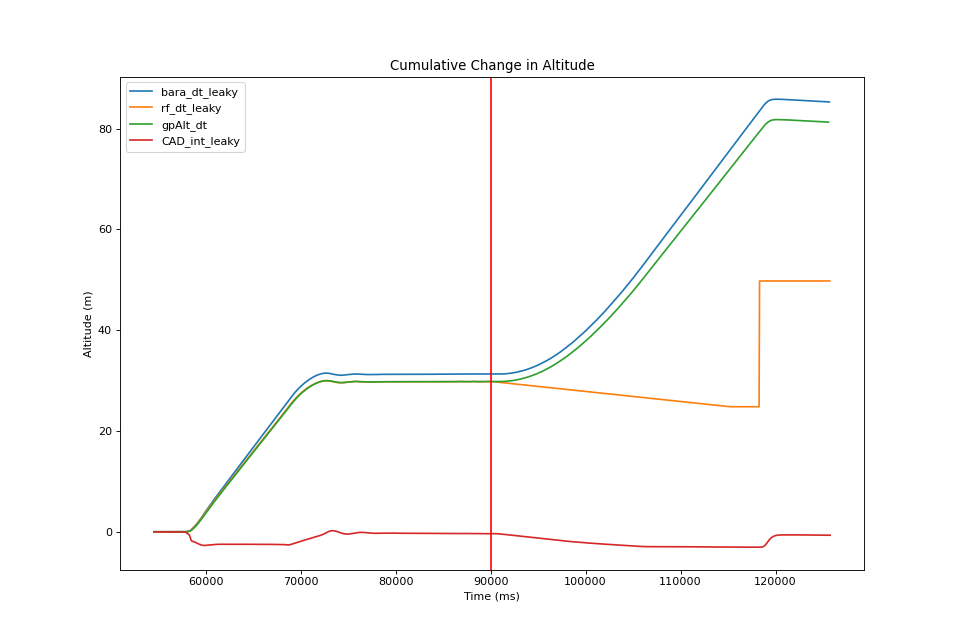

In [2]:
from confirmation.process import change_in_signal, leaky_integrator, trap_integrate
from confirmation.visualize import simple_time_plot
#Need the change_in_signal function to compare change in the percieved altitude
#rather than the raw altitude. 

#Remove duplicate rows for each signal
cUS = df[df.cUS.shift() != df.cUS][["cUS","CAD"]].reset_index()
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf"]].reset_index()
barms = df[df.barms.shift() != df.barms][["barms","bara"]].reset_index()
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","gpAlt"]].reset_index()

#Filtering if necessary, integrate if necessary
alpha = 1
acc_alt = leaky_integrator(trap_integrate(cUS.cUS/1000000, cUS["CAD"]), alpha)
bar_alt = leaky_integrator(change_in_signal(barms.bara), alpha)
rf_alt = leaky_integrator(change_in_signal(rfMS.rf/100), alpha)
gp_alt = change_in_signal(gpsMS.gpAlt/100)

atk = 90069791
simple_time_plot([barms.barms[1:],
                  rfMS.rfMS[1:],
                  gpsMS.gpsMS[1:],
                  cUS.cUS[1:]/1000],
                 [bar_alt.cumsum(),
                  rf_alt.cumsum(),
                  gp_alt.cumsum(),
                  acc_alt.cumsum()],
                 atk=atk/1000,
                title="Cumulative Change in Altitude",
                units=["ms","Altitude (m)"])

We see that before the attack is launched the rangefinder, barometer, and GPS
all track relatively closely. Interestingly the accelerometer does not perform
as well in simulation as we have seen in live testing in the
[live gps spoofing notebook](./0.1-bks-attack-idle.ipynb). This may not be an
issue if this is a quirk of simulating accelerometer data but will not be
confirmed until live testing of the rangefinder spoofing happens. The important
detail is the divergence at the point of spoofing. The rangefinder starts to
drop 5 meters which was the desired value set in the attack parameters while
in response the barometer and gps both start accelerating upward. The 
divergence in readings is what we wish to see for confirmation. To follow the
live data analysis we will perform the same linear biasing and windowing
approach and see if usable data still comes out. The time frame for linear
biasing will start at 76020ms, a visually discerned point where the altitude
measurements seem to enter a steady-state, to avoid poor biasing because of
the take-off period.

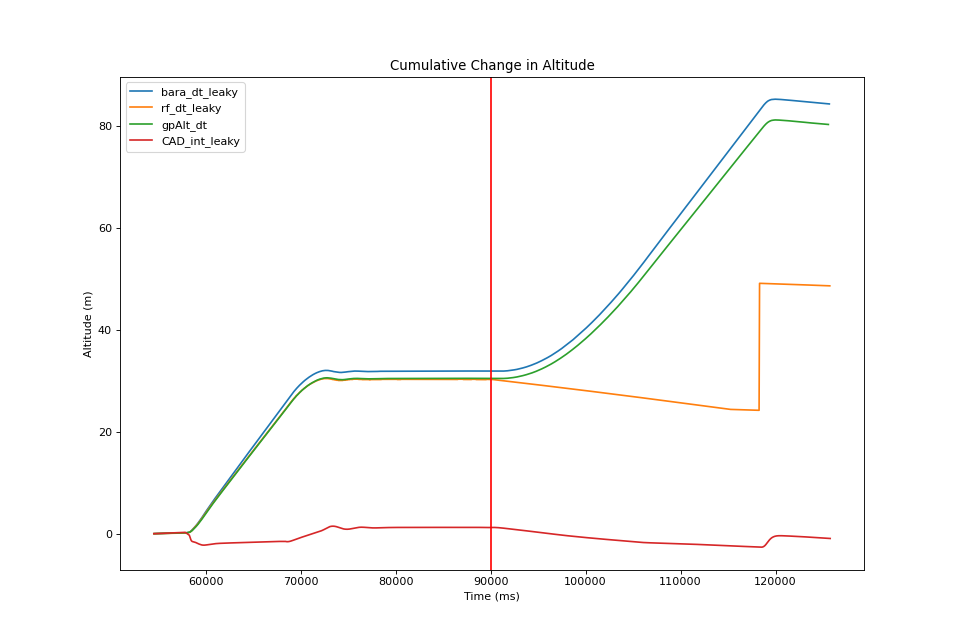

In [3]:
#linear_bias removes a percieved first order drift from the signal. In this
#case the index of time from 0:atk/1000 represents the loiter portion of the
#mission without any attack
from confirmation.process import linear_bias

times = [76020, atk/1000]
simple_time_plot([barms.barms[1:],
                  rfMS.rfMS[1:],
                  gpsMS.gpsMS[1:],
                  cUS.cUS[1:]/1000],
                 [linear_bias(barms.barms[1:], bar_alt, times).cumsum(),
                  linear_bias(rfMS.rfMS[1:], rf_alt, times).cumsum(),
                  linear_bias(gpsMS.gpsMS[1:], gp_alt, times).cumsum(),
                  linear_bias(cUS.cUS[1:]/1000, acc_alt, times).cumsum()],
                 atk=atk/1000,
                title="Cumulative Change in Altitude",
                units=["ms","Altitude (m)"])

Funnily enough it would seem that there is no constant bias to account for
from simulated data so the linear biasing function here causes negligible
change.

#### Windowing

A method for reducing low frequency noise, or a slow drifting bias, is to only
look at sections of the data over time. Methods for looking at sections of the
data can be referred to as filtering, moving averages, windowing, or so forth.
The linear biasing applied before is a method of trying to remove any drift
that can be simply modeled by a linear equation when calibrating the senors in
a static position. What was also used before is the cumulative sum of changes
meaning any change in the signal whether due to noise or actual movement will
forever be kept in the result. This was a more prevalent feature with live data
when the goal was to not look at the changes of the overall signal but to only
focus on subsections that can contain the patterns we are interested in. The
simulated data is of less concern because the issue of noise and biasing is
less prevalent. In this case we could use a much smaller window,i.e., 1 second,
and probably see the attack pattern.

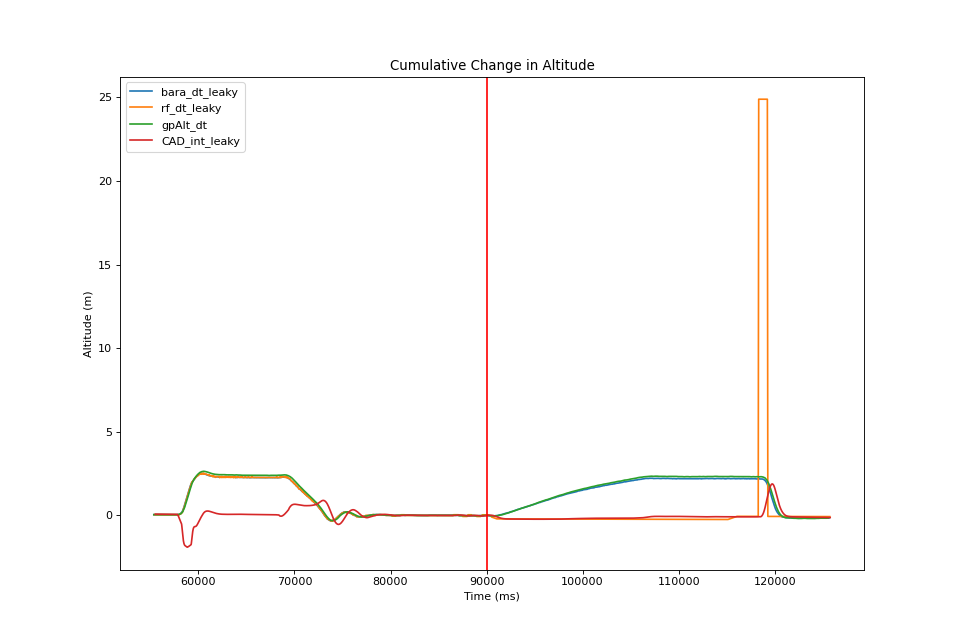

In [4]:
from math import floor

#Each signal has different window size
acc_size = floor(1000000/cUS.cUS.diff().mean())
rf_size = floor(1000/rfMS.rfMS.diff().mean())
gps_size = floor(1000/gpsMS.gpsMS.diff().mean())
bar_size = floor(1000/barms.barms.diff().mean())

simple_time_plot([barms.barms[1:],
                  rfMS.rfMS[1:],
                  gpsMS.gpsMS[1:],
                  cUS.cUS[1:]/1000],
                 [linear_bias(barms.barms[1:], bar_alt, times).rolling(bar_size).sum(),
                  linear_bias(rfMS.rfMS[1:], rf_alt, times).rolling(rf_size).sum(),
                  linear_bias(gpsMS.gpsMS[1:], gp_alt, times).rolling(gps_size).sum(),
                  linear_bias(cUS.cUS[1:]/1000, acc_alt, times).rolling(acc_size).sum()],
                 atk=atk/1000,
                title="Cumulative Change in Altitude",
                units=["ms","Altitude (m)"])

Alright great, we have what appears to be signals that are almost the same with
significant differences removed from the results over time because of the
windowing. Now that we have the final representation of our signals we can look
at the statistics of the signal differences. The function 
`signal_match_and_cumsum` will take two signals, sum the faster signal readings
in between the slower signal updates and save the results when the slower
signal does update. The purpose of this is the different update rates requires
some form of interpolation to fill in data at the appropriate timestamps to 
directly compare the signals. To reduce the amount of signal that is loss at
the point of confirmation the faster signal is essentially "binned" into the
slower sensors time frames. To verify the correct implementation both the
original and "binned" signals are shown below which will be the same if
implemented properly.

In [5]:
test1 = change_in_signal(barms.bara)
test2 = change_in_signal(gpsMS.gpAlt/100)

In [6]:
x_ts = barms.barms[1:].reset_index(drop=True)
y_ts = gpsMS.gpsMS[1:].reset_index(drop=True)

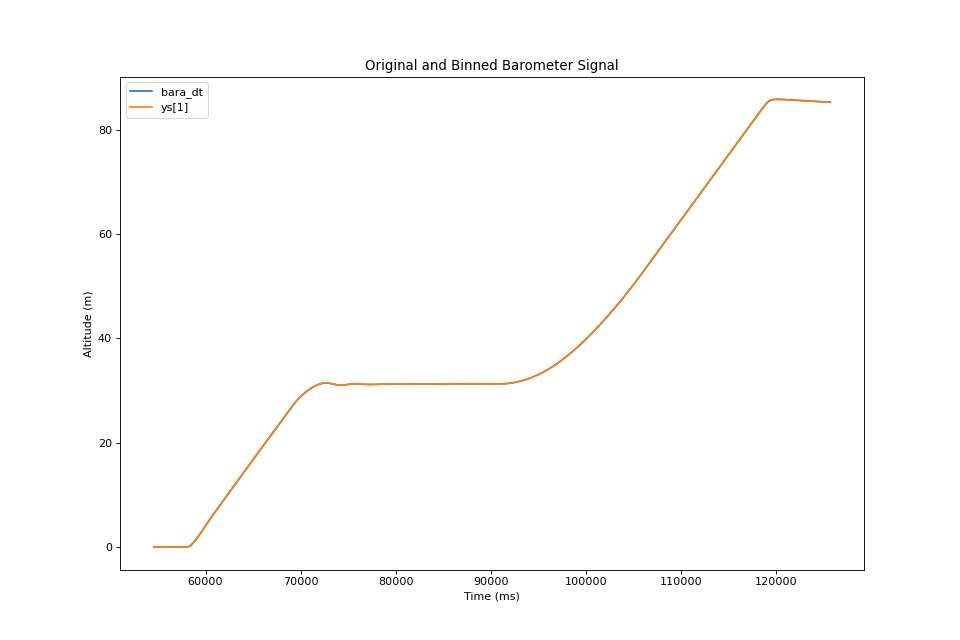

In [7]:
from confirmation.process import signal_match_and_cumsum
res = signal_match_and_cumsum(barms.barms[1:].reset_index(drop=True),
                              change_in_signal(barms.bara),
                              gpsMS.gpsMS[1:].reset_index(drop=True),
                              change_in_signal(gpsMS.gpAlt/100))
simple_time_plot([x_ts, y_ts],
                 [change_in_signal(barms.bara).cumsum(), res],
                title="Original and Binned Barometer Signal",
                units=["ms","Altitude (m)"])

Great, exactly what we want to see. Both signals when plotted with pyplot will
be interpolated to fit the same axis by default, but what is important is that
these signals have different lengths due to being binned. Although the signals
have different lengths they represent the same signal, except one is now in a
form that can be compared to the GPS signal.

The attack is clearly noticable in the windowed data. The divergence at where
the attack starts is consistent and should be easily detected. We will take a
closer look at the actual signal behavior below to see how these simulated
results compare to datasheet error estimates.

#### Statistics of These Signals Compared to Theory

Now that these signals are grouped well enough we can start looking at the
statistical details of the signals and how they relate to determine if sensor
confirmation would be possible here. The simplest approach taken is to take
the absolute difference in any 2 signals and determine at what value 99.7% of
the signals fall below. Finding where 99.7% of values fall under is the
sensor confirmation approach that wants to consider signal differences and
compare the result to datasheet reported or empirically derived noise
distributions.

In [8]:
rf = signal_match_and_cumsum(rfMS.rfMS[1:].reset_index(drop=True), change_in_signal(rfMS.rf/100),
                            barms.barms[1:].reset_index(drop=True), change_in_signal(barms.bara))

rf = linear_bias(barms.barms[2:], change_in_signal(rf), times).rolling(bar_size).sum()
rf = pd.Series(rf, name="rf_dt")

bar = linear_bias(barms.barms[1:], bar_alt, times).rolling(bar_size).sum()

#### RF and Barometer

In [9]:
#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = barms.barms[barms.barms < atk/1000][-1:].index[0]

#We also need the point at which the attack is disabled to remove the data
#points following from the analysis otherwise they will skew the analysis.
end_index = barms.barms[barms.barms < 118265][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Bar and GPS during benign 99.7%%: %.5fm" % np.percentile(abs(bar - rf)[:atk_index].dropna(), 99.7))
print("Bar and GPS during attack 99.7%%: %.5fm" % np.percentile(abs(bar - rf)[atk_index:end_index].dropna(), 99.7))

Bar and GPS during benign 99.7%: 0.22368m
Bar and GPS during attack 99.7%: 2.41852m


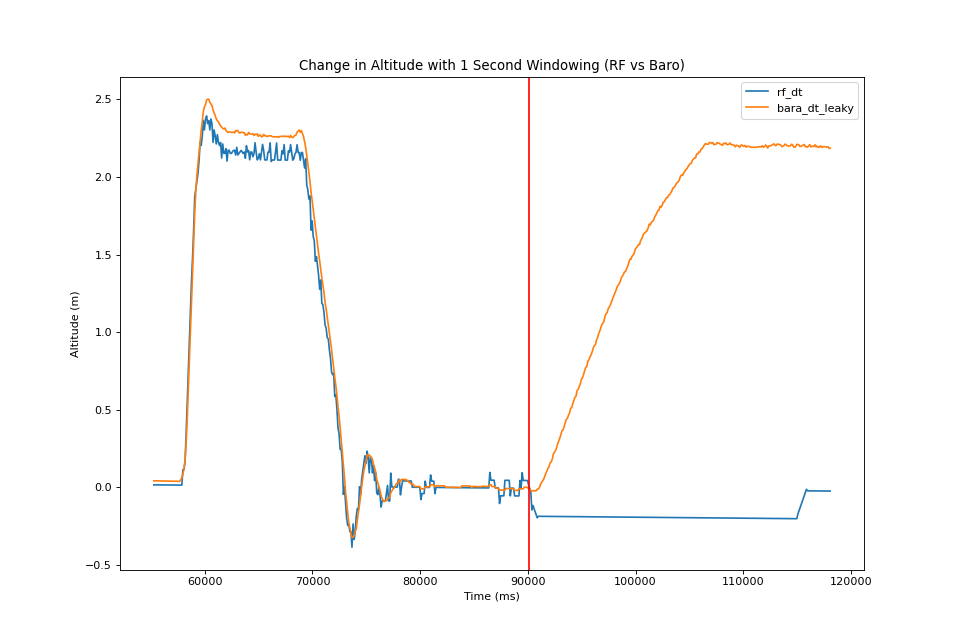

In [10]:
simple_time_plot([barms.barms[:end_index],barms.barms[1:end_index]],
                 [rf[:end_index], bar[1:end_index]],
                title = "Change in Altitude with 1 Second Windowing (RF vs Baro)",
                units = ["ms","Altitude (m)"],
                atk=atk/1000)

#### Conclusion

This notebook showed an analysis of simulated data with the purpose of seeing
whether sensor confirmation could be applied to detect an attack on the
rangefinder. We have shown that the magnitude of difference between a benign
setting and an attacked setting is almost 10 times different, a significant
margin when detecting an attacker in 1 second windows. The graph shown above
also clearly demonstrates the divergence in the two signals even when
windowing is applied. There are more sensors that could be applied here but
due to the nature of simulated data this will be the extent of the analysis
on simulating the attack in a simulated environment. When the simulated attack
on the rangefinder is field tested and the data analyzed a link to the notebook
will be added below.